# Replication of paper "Approximate Bayesian computational methods" (2011)

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

### **Alorithm 1** - Likelihood-free rejection sampler 1
Let's use sampling from Uniform with binomial likelihood function to illustrate this algorithm.

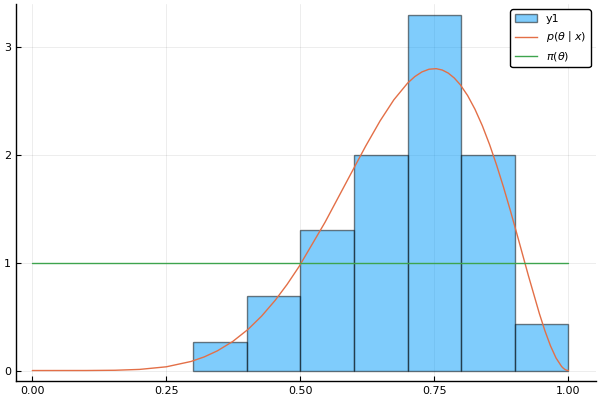

In [3]:
n, x = 8, 6
N = 1000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

### **Alorithm 2** - Likelihood-free rejection sampler 2

Let's write the functions for calculating the distances between the variables.

##### a) **Moving Average Model**

In [277]:
MA(current, u,t) = u[current+2] + u[current + 1] * t[2] + u[current] * t[1]

function genMA(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

genMA (generic function with 2 methods)

##### b) **Synthetic Dataset**
###### Moving Average model (MA)
$y_k = u_k + \sum_{i=1}^q \theta_i u_{k-i}$

$y \sim MA(q)$

$(\theta_1,\theta_2) =(0.6,0.2)$,sample size of 100.

In [289]:
using Random
Random.seed!(1234)
theta = [0.6;0.2]
n     = 100
u     = randn(n+2)
y     = MA.((1:n),Ref(u),Ref(theta));
# y     = genMA(u',theta',n,1)

##### c) **Distance Functions and Suffient Statistics**

In [290]:
raw_distance(y,z)         = sqrt(sum((y-z).^2))
raw_distance_ordered(y,z) = sqrt(sum((sort(y)-sort(z)).^2))
autocov_distance(q,y,z)   = sqrt((autocov(y,[q],demean=false)[1] - autocov(z,[q],demean=false)[1])^2)[1]

# Example
y = rand(10)
z = rand(10)
raw_distance(y,z),raw_distance_ordered(y,z), autocov_distance(2,y,z)

(1.1877820283726312, 0.17722769085447343, 0.026346706335622305)

##### d) **Running Algorithm 2**

In [282]:
y = randn(10)
N = 10        # number of trials
n = length(y) # sample size
theta_s = rand(N,2)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);